# Earnings Forecast - Roland Berger Analytics Screening

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import r2_score


In [2]:
sp500 = pd.read_csv('SP500_FUND_A_16052019.csv', index_col=0)

print('Number of rows: ', sp500.shape[0])
print('Number of Features: ', sp500.shape[1])

sp500.head()

Number of rows:  5339
Number of Features:  118


,ticker,date,year,month,day,fyear,fmonth,ass_c_y,ass_nc_y,ass_tax_y,...,rat_y,rev_r_d_y,rev_s_g_a_y,roic_y,turn_acc_pay_y,turn_acc_rec_y,turn_inv_y,wrk_cap_y,fyearold,n2
v1,,,,,,,,,,,,,,,,,,,,,
1,a,2007-10-31,2007,10,31,2007,10,3.671000e+09,3.883000e+09,0.0,...,2.207,0.1264,0.3137,0.1490,4.1255,7.5964,8.5354,2.008000e+09,2007,1
2,a,2008-10-31,2008,10,31,2008,10,3.182000e+09,3.825000e+09,0.0,...,2.392,0.1219,0.2939,0.1864,4.6941,7.6731,8.9589,1.852000e+09,2008,1
3,a,2009-10-31,2009,10,31,2009,10,3.961000e+09,3.651000e+09,0.0,...,3.527,0.1433,0.3577,0.0121,3.7951,6.5656,7.4808,2.838000e+09,2009,1
4,a,2010-10-31,2010,10,31,2010,10,6.169000e+09,3.527000e+09,0.0,...,2.001,0.1124,0.3218,0.0905,3.9107,7.4372,8.5868,3.086000e+09,2010,1
5,a,2011-10-31,2011,10,31,2011,10,5.569000e+09,3.488000e+09,0.0,...,3.032,0.0981,0.2735,0.1700,3.5592,7.6518,8.1970,3.732000e+09,2011,1


## 1. Data Preparation

### 1.1 Dataset containing 23 predictors

In [3]:
selection = ['ticker', 'date', 'year', 'month', 'day', 'fyear', 'fmonth', 'shr_y', 'ass_tot_y', 'goodwill_y', 'inc_rea_y', 'invest_y', 'rev_def_y', 'dps_y',
                'exp_r_d_y', 'marg_profit_y', 'rev_grw_y', 'cf_inv_y', 'exp_cap_y',
                'ncf_bad_y', 'ncf_iad_y', 'g_cf_op_y', 'g_dps_y', 'g_eps_y', 'g_inv_y',
                'be_ps_y', 'fcf_ps_y', 'inc_qua_y', 'payout_y', 'turn_inv_y', 'eps_y']


sp500_selected = sp500[selection]

### Handling Missing Data

In [4]:
# 1. Calculate Count and Percentage
missing_count = sp500_selected.isnull().sum()
missing_pct = (sp500_selected.isnull().mean() * 100)

# 2. Combine into a clean DataFrame
missing_summary = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing %': missing_pct
})

# 3. Sort by percentage descending to see the worst columns first
missing_summary = missing_summary.sort_values(by='Missing %', ascending=False)

# 4. Filter to show only columns that actually have missing data
missing_only = missing_summary[missing_summary['Missing Count'] > 0]

# Display
print("--- Missing Data Summary ---")
if not missing_only.empty:
    display(missing_only.style.background_gradient(cmap='Reds', subset=['Missing %']).format({'Missing %': "{:.2f}%"}))
else:
    print("No missing values found in the selected subset!")

--- Missing Data Summary ---


,Missing Count,Missing %
turn_inv_y,119,2.23%
g_inv_y,112,2.10%
inc_rea_y,111,2.08%
payout_y,95,1.78%
g_eps_y,89,1.67%
fcf_ps_y,80,1.50%
be_ps_y,80,1.50%
rev_grw_y,77,1.44%
inc_qua_y,77,1.44%
shr_y,71,1.33%


Generally speaking, the share of missing data is very low. We will handle it, however, this will most likely not have a significant impact on our models.

In [5]:
def handle_missing_data(df, predictors, drop_threshold=0.5):
    """
    1. Removes companies with > 50% missing data.
    2. Imputes missing values using Ticker Mean (Primary).
    3. Imputes remaining missing values using Global Mean (Secondary).
    """
    df_clean = df.copy()
    
    # ---------------------------------------------------------
    # STEP A: THE DELETION RULE (Filter out 'Empty' Companies)
    # ---------------------------------------------------------
    print("--- Step 1: Applying Deletion Rule ---")
    
    # Calculate percentage of missing data per TICKER across all predictor columns
    # resulting series: Index=ticker, Value=0.0 to 1.0 (percent missing)
    ticker_missing_pct = df_clean.groupby('ticker')[predictors].apply(
        lambda x: x.isnull().mean().mean()
    )
    
    # Identify bad tickers
    bad_tickers = ticker_missing_pct[ticker_missing_pct > drop_threshold].index.tolist()
    
    # Drop them
    initial_rows = len(df_clean)
    df_clean = df_clean[~df_clean['ticker'].isin(bad_tickers)]
    dropped_rows = initial_rows - len(df_clean)
    
    print(f"Rule: Drop tickers with > {drop_threshold*100}% missing data.")
    print(f"Dropped {len(bad_tickers)} companies ({dropped_rows} rows).")
    
    # ---------------------------------------------------------
    # STEP B: HIERARCHICAL IMPUTATION
    # ---------------------------------------------------------
    print("\n--- Step 2: Running Imputation (Ticker Mean -> Global Mean) ---")
    
    impute_stats = {'Ticker_Imputed': 0, 'Global_Imputed': 0}
    
    for col in predictors:
        # Check if column has missing data
        n_missing = df_clean[col].isnull().sum()
        if n_missing == 0:
            continue
            
        # 1. Calculate Ticker Mean (returns a Series aligned with df_clean)
        # transform('mean') broadcasts the group mean to every row of that group
        ticker_means = df_clean.groupby('ticker')[col].transform('mean')
        
        # 2. Fill with Ticker Mean first
        # We define a mask to count how many we fix here
        filled_by_ticker = df_clean[col].fillna(ticker_means)
        n_fixed_ticker = n_missing - filled_by_ticker.isnull().sum()
        impute_stats['Ticker_Imputed'] += n_fixed_ticker
        
        # Apply the fill
        df_clean[col] = filled_by_ticker
        
        # 3. Fill remaining with Global Mean
        remaining_missing = df_clean[col].isnull().sum()
        if remaining_missing > 0:
            global_mean = df_clean[col].mean()
            df_clean[col] = df_clean[col].fillna(global_mean)
            impute_stats['Global_Imputed'] += remaining_missing

    print(f"Values filled using Ticker Mean: {impute_stats['Ticker_Imputed']}")
    print(f"Values filled using Global Mean: {impute_stats['Global_Imputed']}")
    
    return df_clean

# ==========================================
# EXECUTION
# ==========================================

# Define your predictor list (excluding dates/strings)
# Assuming 'df_predictors' from previous steps holds the column names
numeric_predictors = sp500_selected.select_dtypes(include=[np.number]).columns.tolist()

# Run the function on your winsorized/shifted dataset
# (Make sure to use the dataset BEFORE creating targets if you want predictors clean, 
# or AFTER if you want everything clean. Usually done before creating Lag/Shift vars)
sp500_imputed = handle_missing_data(sp500_selected, numeric_predictors, drop_threshold=0.5)

# Verification: Should be 0 missing
print(f"\nRemaining Missing Values: {sp500_imputed[numeric_predictors].isnull().sum().sum()}")

--- Step 1: Applying Deletion Rule ---
Rule: Drop tickers with > 50.0% missing data.
Dropped 0 companies (0 rows).

--- Step 2: Running Imputation (Ticker Mean -> Global Mean) ---
Values filled using Ticker Mean: 1144
Values filled using Global Mean: 266

Remaining Missing Values: 0


### 1.2 Scaling variables of variables - share / absolute level

First, let's assess if the number of stocks vary over time. This helps us decide for an approach of scaling to the per stock level, leaving the numbers in absolute terms or using an alternative method.

For many of the companies in the dataset, share number vary over time. A share split for example would cause the share number to double, while the earnings per share would halve.

However, after assessing whether to scale the varaibles that are recorded in absolute terms, for the purpose of this exercise, we will scale all variables to a per share level.

For a more extensive analysis than a 24h project, one could further assess to use relative metrics, such as R&D spend / revenue.

In [6]:
# all variables that are on a absolute level that are to be scaled on a per share basis
# -> ratios and percentages are not considered here

absolute_variables_to_scale = {
    'ass_tot_y': 'ass_ps_y',
    'goodwill_y': 'goodwill_ps_y',
    'inc_rea_y': 'inc_rea_ps_y',
    'invest_y': 'invest_ps_y',
    'rev_def_y': 'rev_def_ps_y',
    'exp_r_d_y': 'exp_r_d_ps_y',
    'cf_inv_y': 'cf_inv_ps_y',
    'exp_cap_y': 'exp_cap_ps_y',
    'ncf_bad_y': 'ncf_bad_ps_y',
    'ncf_iad_y': 'ncf_iad_ps_y',
}

# scale each variable
for original, new_name in absolute_variables_to_scale.items():
    sp500_imputed[new_name] = sp500_imputed[original] / sp500_imputed['shr_y']

# update predictor columns list with new per-share variables
predictor_cols_scaled = [
    'ticker',           # 0. Company ticker
    'date',             # 0. Time stemp
    'year',             # 0. Time stemp
    'month',            # 0. Time stemp
    'day',              # 0. Time stemp
    'fyear',            # 0. Time stemp
    'fmonth',           # 0. Time stemp
    'shr_y',            # 0. Number of shares

    'ass_ps_y',         # 1. Scaled (was ass_tot_y)
    'goodwill_ps_y',    # 2. Scaled (was goodwill_y)
    'inc_rea_ps_y',     # 3. Scaled (was inc_rea_y)
    'invest_ps_y',      # 4. Scaled (was invest_y)
    'rev_def_ps_y',     # 5. Scaled (was rev_def_y)
    'dps_y',            # 6. Unchanged
    'exp_r_d_ps_y',     # 7. Scaled (was exp_r_d_y)
    'marg_profit_y',    # 8. Unchanged
    'rev_grw_y',        # 9. Unchanged
    'cf_inv_ps_y',      # 10. Scaled (was cf_inv_y)
    'exp_cap_ps_y',     # 11. Scaled (was exp_cap_y)
    'ncf_bad_ps_y',     # 12. Scaled (was ncf_bad_y)
    'ncf_iad_ps_y',     # 13. Scaled (was ncf_iad_y)
    'g_cf_op_y',        # 14. Unchanged
    'g_dps_y',          # 15. Unchanged
    'g_eps_y',          # 16. Unchanged
    'g_inv_y',          # 17. Unchanged
    'be_ps_y',          # 18. Unchanged (Already per share)
    'fcf_ps_y',         # 19. Unchanged (Already per share)
    'inc_qua_y',        # 20. Unchanged
    'payout_y',         # 21. Unchanged
    'turn_inv_y',       # 22. Unchanged
    'eps_y',            # 23. UNCHANGED - TARGET
]

# Now use predictor_cols_scaled for your analysis
sp500_scaled = sp500_imputed[predictor_cols_scaled]
sp500_scaled.head()

,ticker,date,year,month,day,fyear,fmonth,shr_y,ass_ps_y,goodwill_ps_y,...,g_cf_op_y,g_dps_y,g_eps_y,g_inv_y,be_ps_y,fcf_ps_y,inc_qua_y,payout_y,turn_inv_y,eps_y
v1,,,,,,,,,,,,,,,,,,,,,
1,a,2007-10-31,2007,10,31,2007,10,394000000.0,19.172589,1.868020,...,0.5284,0.0,-0.7888,0.0255,8.601,2.099,1.5188,0.0,8.5354,1.62
2,a,2008-10-31,2008,10,31,2008,10,363000000.0,19.303030,2.407713,...,-0.2198,0.0,0.1790,0.0047,7.168,1.697,1.0909,0.0,8.9589,1.91
3,a,2009-10-31,2009,10,31,2009,10,346000000.0,22.000000,2.375723,...,-0.4603,0.0,-1.0471,-0.1455,7.306,0.812,-13.1613,0.0,7.4808,-0.09
4,a,2010-10-31,2010,10,31,2010,10,347000000.0,27.942363,5.619597,...,0.7598,0.0,22.8889,0.2971,9.384,1.741,1.0497,0.0,8.5868,1.97
5,a,2011-10-31,2011,10,31,2011,10,347000000.0,26.100865,5.752161,...,0.7549,0.0,0.4822,0.2542,12.415,3.141,1.2451,0.0,8.1970,2.92


### 1.3 Creating target variables - This is done after the outlier handling, as this will also be affecting the target variable.

### Check for structural breaks due to stock splits

In [7]:
df_shr_changes = sp500_imputed.groupby('ticker')['shr_y'].nunique()
tickers_with_shr_changes = df_shr_changes[df_shr_changes > 1].index.tolist()

if tickers_with_shr_changes:
    print(f"The 'shr_y' (shares per year) changes over time for the following tickers: {tickers_with_shr_changes}")
else:
    print("The 'shr_y' (shares per year) does not change over time for any ticker in the dataset.")


The 'shr_y' (shares per year) changes over time for the following tickers: ['a', 'aal', 'aap', 'aapl', 'abbv', 'abc', 'abt', 'acn', 'adbe', 'adi', 'adm', 'adp', 'ads', 'adsk', 'aee', 'aep', 'aes', 'aet', 'afl', 'agn', 'aig', 'aiv', 'aiz', 'ajg', 'akam', 'aks', 'alb', 'alk', 'all', 'alle', 'alxn', 'amat', 'amd', 'ame', 'amg', 'amgn', 'amp', 'amt', 'amzn', 'an', 'anf', 'antm', 'aon', 'apa', 'apc', 'apd', 'aph', 'are', 'arnc', 'ati', 'atvi', 'avb', 'avgo', 'avp', 'avy', 'awk', 'axp', 'ayi', 'azo', 'ba', 'bac', 'bax', 'bbby', 'bbt', 'bby', 'bc', 'bcr', 'bdx', 'ben', 'bfb', 'big', 'biib', 'bk', 'blk', 'bll', 'bms', 'bmy', 'brkb', 'bsx', 'bwa', 'bxp', 'c', 'ca', 'cag', 'cah', 'cat', 'cb', 'cbg', 'cboe', 'cbs', 'cce', 'cci', 'ccl', 'celg', 'cern', 'cf', 'cfg', 'chd', 'chk', 'chrw', 'chtr', 'ci', 'cien', 'cinf', 'cl', 'clf', 'clx', 'cma', 'cmcsa', 'cme', 'cmg', 'cmi', 'cms', 'cnc', 'cnp', 'cnx', 'cof', 'cog', 'coh', 'col', 'coo', 'cop', 'cost', 'coty', 'cpb', 'crm', 'csco', 'csx', 'ctas', 'ctl

Before moving on to the EDA, we want to first make sure that the data is prepared properly.

#### Previous assumption was that a stock split for example might cause a significant structural break in the data.
First research has yielded that this might not be the case, because EPS is always reported on a split-adjusted basis by financial data providers. However, we want to check if this is the case and if so, adjust for it.

We will research one specific commpanies where a stock split occurred in the time period of the data. Then we will check if the data is actually reported on a split-adjusted basis to validate our new hypothesis.

According to credible sources, including the company website, Nike (ticker: nke) had a 2-for1 stock split in 12/23/2015. Accordingly, we will check how the number of shares changed over time:


https://investors.nike.com/default.aspx?SectionId=d8f26c6c-d0e6-416b-af21-d4193a16d945&LanguageId=1

In [8]:
nke = sp500_scaled[sp500_scaled['ticker'] == 'nke'] 

print(nke[nke['year'].isin([2014, 2015, 2016])]['shr_y'])


v1
3632    1.756278e+09
3633    1.719495e+09
3634    1.684722e+09
Name: shr_y, dtype: float64


Accordingly, as the number of shares does not double from 2015 to 2016, we can continue with this hypothesis and now have confirmed that there is *no adjustment necessary*.

### 1.4 Outlier Detection & Treatment

### a. Identification of Outliers

In [9]:
def detect_outliers_and_bounds(df, features, threshold=1.5):
    """
    Detects outliers using IQR method and calculates bounds for winsorizing.
    
    Parameters:
    - df: The dataframe
    - features: List of continuous variables to check
    - threshold: IQR multiplier (Standard is 1.5)
    
    Returns:
    - outlier_flags: DataFrame with binary outlier flags (1=outlier, 0=normal)
    - bounds: Dictionary with lower/upper bounds for each feature
    """
    print(f"--- Detecting Outliers (IQR Threshold={threshold}) ---")
    
    outlier_flags = pd.DataFrame(index=df.index)
    bounds = {}
    
    for col in features:
        if col not in df.columns:
            continue
            
        # Calculate IQR Bounds
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - (threshold * IQR)
        upper_bound = Q3 + (threshold * IQR)
        
        # Store bounds for winsorizing
        bounds[col] = {'lower': lower_bound, 'upper': upper_bound}
        
        # Flag outliers
        is_outlier = (df[col] < lower_bound) | (df[col] > upper_bound)
        outlier_flags[col] = is_outlier.astype(int)
    
    return outlier_flags, bounds


def count_outliers_by_ticker(df, outlier_flags):
    """
    Counts how many individual outlier values exist for each ticker.
    
    Parameters:
    - df: The dataframe (must contain a 'ticker' column)
    - outlier_flags: DataFrame with binary outlier flags
    
    Returns:
    - results: DataFrame sorted by most outliers, filtered for tickers with >= 1
    """
    print(f"--- Aggregating Outliers by Ticker ---")
    
    # Add Ticker column back for grouping
    outlier_flags_copy = outlier_flags.copy()
    
    if 'ticker' in df.columns:
        outlier_flags_copy['ticker'] = df['ticker'].values
    else:
        outlier_flags_copy['ticker'] = df.index.get_level_values('ticker')

    # Group by Ticker and Sum
    ticker_totals = outlier_flags_copy.groupby('ticker').sum()
    
    # Sum across columns to get grand total per ticker
    results = pd.DataFrame()
    results['outlier_count'] = ticker_totals.sum(axis=1)
    
    # Filter: Minimum of 1 outlier
    results = results[results['outlier_count'] >= 1]
    
    # Sort descending
    results = results.sort_values(by='outlier_count', ascending=False)
    
    return results

In [10]:
# Select numeric features for outlier detection
features_ol_id = sp500_scaled.select_dtypes(include=np.number).columns.drop(
    ['ticker', 'date', 'year', 'month', 'fyear', 'fmonth', 'shr_y'], 
    errors='ignore'
).tolist()

# Detect outliers and get bounds (run once, use twice)
outlier_flags, outlier_bounds = detect_outliers_and_bounds(sp500_scaled, features_ol_id, threshold=1.5)

# Count outliers per company
outliers_per_company = count_outliers_by_ticker(sp500_scaled, outlier_flags)

# Calculate total data points checked
total_data_points = len(sp500_scaled) * len(features_ol_id)
total_outliers = outlier_flags.sum().sum()
outlier_percentage = (total_outliers / total_data_points) * 100

print(f"\nTotal data points checked: {total_data_points:,}")
print(f"Total outliers detected: {total_outliers:,} ({outlier_percentage:.2f}%)")
print(f"Companies with outliers: {len(outliers_per_company)} out of {sp500_scaled['ticker'].nunique()}")

# Display top companies with most outliers
outliers_per_company.head(10)

--- Detecting Outliers (IQR Threshold=1.5) ---
--- Aggregating Outliers by Ticker ---

Total data points checked: 128,136
Total outliers detected: 17,154 (13.39%)
Companies with outliers: 578 out of 579


,outlier_count
ticker,
ghc,163
brkb,118
aig,102
googl,98
ftr,97
c,95
gs,91
fnma,87
cb,84


Accordingly, around 14% of the feature & target values present in the dataset outliers. With an absolute count of 18,028 outliers, these extreme values possess high leverage that would disproportionately skew the coefficients of a General Linear Model (GLM), undermining its predictive accuracy for the broader market.
As one can see, most of the outliers are present in the large companies of the S&P 500 (IBM, Citi Group, Google, Apple, Microsoft, ect.), which are much bigger than the some of the smaller companies represented in the S&P500.

In [11]:
outlier_flags, outlier_bounds = detect_outliers_and_bounds(sp500_scaled, features_ol_id, threshold=2.5)

# Count outliers per company
outliers_per_company = count_outliers_by_ticker(sp500_scaled, outlier_flags)

# Calculate total data points checked
total_data_points = len(sp500_scaled) * len(features_ol_id)
total_outliers = outlier_flags.sum().sum()
outlier_percentage = (total_outliers / (len(sp500_scaled) * len(features_ol_id))) * 100

print("\n")
print(f"Total outliers detected: {total_outliers:,} ({outlier_percentage:.2f}%)")

--- Detecting Outliers (IQR Threshold=2.5) ---
--- Aggregating Outliers by Ticker ---


Total outliers detected: 12,056 (9.41%)


This will will accordingly result in capping/clipping ~10% of the values in the dataset, reducing the share of altered data.

### b. Handling of Outliers

Since the occurrences of outliers is quite high, we will use the winsorization method with an adjusted threshold of 2.5 to reduce the impact of the most extreme values while not altering too much of the original data.

Whether to winsorize the target feature along with the predictors is a trade-off between stabilizing the regression model and preserving rare but true observations.
The decision to also winsorize the target variable was made to ensure structural consistency, as attempting to predict extreme target values using capped or clipped predictors creates an unbalanced equation that forces the GLM to artificially inflate coefficients.

In [12]:
def winsorize_data(df, features, bounds):
    """
    Winsorizes data by capping outliers at the IQR bounds.
    
    Parameters:
    - df: The dataframe to winsorize
    - features: List of features to winsorize
    - bounds: Dictionary of bounds from detect_outliers_and_bounds
    
    Returns:
    - df_winsorized: DataFrame with outliers capped at bounds
    """
    print(f"--- Winsorizing {len(features)} features ---")
    
    df_winsorized = df.copy()
    winsorized_count = 0
    
    for col in features:
        if col not in bounds or col not in df_winsorized.columns:
            continue
            
        lower = bounds[col]['lower']
        upper = bounds[col]['upper']
        
        # Count how many values will be winsorized
        n_lower = (df_winsorized[col] < lower).sum()
        n_upper = (df_winsorized[col] > upper).sum()
        winsorized_count += n_lower + n_upper
        
        # Cap values at bounds
        df_winsorized[col] = df_winsorized[col].clip(lower=lower, upper=upper)
    
    print(f"Winsorized {winsorized_count} values across all features")
    return df_winsorized


Therefore, we need to calculate the new 2.5 IQR bounds for the windorizing.

In [13]:
def get_iqr_bounds(df, features, threshold):
    bounds = {}
    for col in features:
        if col not in df.columns: continue
        
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        bounds[col] = {
            'lower': Q1 - (threshold * IQR),
            'upper': Q3 + (threshold * IQR)
        }
    return bounds


    

In [14]:
_, new_bounds = detect_outliers_and_bounds(sp500_scaled, features_ol_id, threshold=2.5)

# Apply winsorizing using the bounds we already calculated
sp500_winsorized = winsorize_data(sp500_scaled, features_ol_id, new_bounds)
# Verify winsorizing worked - should have 0 outliers with same bounds
outlier_flags_after, _ = detect_outliers_and_bounds(sp500_winsorized, features_ol_id, threshold=2.5)
print(f"\nOutliers remaining after winsorizing: {outlier_flags_after.sum().sum()}")

sp500_winsorized

--- Detecting Outliers (IQR Threshold=2.5) ---
--- Winsorizing 24 features ---
Winsorized 12056 values across all features
--- Detecting Outliers (IQR Threshold=2.5) ---

Outliers remaining after winsorizing: 0


,ticker,date,year,month,day,fyear,fmonth,shr_y,ass_ps_y,goodwill_ps_y,...,g_cf_op_y,g_dps_y,g_eps_y,g_inv_y,be_ps_y,fcf_ps_y,inc_qua_y,payout_y,turn_inv_y,eps_y
v1,,,,,,,,,,,,,,,,,,,,,
1,a,2007-10-31,2007,10,31,2007,10,394000000.0,19.172589,1.868020,...,0.5284,0.0000,-0.788800,0.0255,8.601,2.099,1.5188,0.000,8.5354,1.62
2,a,2008-10-31,2008,10,31,2008,10,363000000.0,19.303030,2.407713,...,-0.2198,0.0000,0.179000,0.0047,7.168,1.697,1.0909,0.000,8.9589,1.91
3,a,2009-10-31,2009,10,31,2009,10,346000000.0,22.000000,2.375723,...,-0.4603,0.0000,-1.047100,-0.1455,7.306,0.812,-1.7409,0.000,7.4808,-0.09
4,a,2010-10-31,2010,10,31,2010,10,347000000.0,27.942363,5.619597,...,0.7598,0.0000,1.706975,0.2971,9.384,1.741,1.0497,0.000,8.5868,1.97
5,a,2011-10-31,2011,10,31,2011,10,347000000.0,26.100865,5.752161,...,0.7549,0.0000,0.482200,0.2542,12.415,3.141,1.2451,0.000,8.1970,2.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5473,zts,2012-12-31,2012,12,31,2012,12,500000000.0,12.524000,3.706000,...,-0.0865,0.0000,0.775500,0.2653,8.052,0.656,1.0413,0.000,3.6013,0.87
5474,zts,2013-12-31,2013,12,31,2013,12,500002000.0,13.115948,3.569986,...,0.5000,0.0000,0.160900,-0.0387,1.880,0.994,1.3512,0.198,3.4579,1.01
5475,zts,2014-12-31,2014,12,31,2014,12,501055000.0,13.148257,3.398828,...,-0.0808,0.4500,0.148500,-0.0031,2.614,0.890,1.0738,0.250,3.7064,1.16


### ---- Creation of target variables (as per 1.3)

In [15]:
Y = sp500_winsorized
Y['neg_eps'] = (Y['eps_y'] < 0).astype(int)

Y['eps_y_forward'] = Y['eps_y'].shift(-1)
Y['neg_eps_forward'] = Y['neg_eps'].shift(-1)


# filter out data where year is 2016, as there, we do not have the 'eps_y_forward' value we want to predict
Y = Y[Y['year'] < 2016]

Y.head(10)


Y_reg = Y['eps_y_forward']
Y_class = Y['neg_eps_forward']
Y_reg

v1
1       1.91
2      -0.09
3       1.97
4       2.92
5       3.31
        ... 
5472    0.87
5473    1.01
5474    1.16
5475    0.68
5476    1.66
Name: eps_y_forward, Length: 4756, dtype: float64

### 1.5 EDA

#### Distribution of Earnings per Share

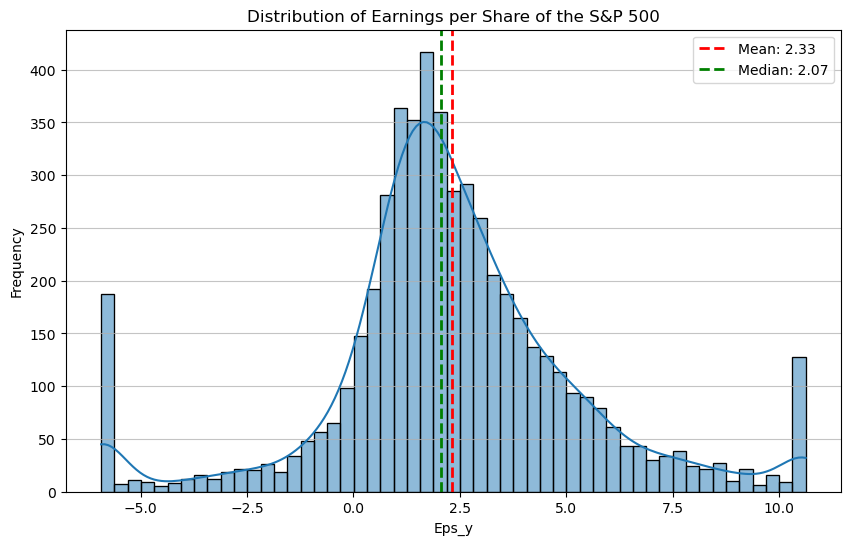

In [16]:
mean_eps_y = sp500_winsorized['eps_y'].mean()
median_eps_y = sp500_winsorized['eps_y'].median()

plt.figure(figsize=(10, 6))
sns.histplot(sp500_winsorized['eps_y'], bins='auto', kde=True)
plt.axvline(mean_eps_y, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_eps_y:.2f}')
plt.axvline(median_eps_y, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_eps_y:.2f}')
plt.title('Distribution of Earnings per Share of the S&P 500')
plt.xlabel('Eps_y')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()


Representative for the overall dataset after windsorizing, one can see the 'inflated' tails on the very far sides of the histogram.
This is due to the fact that the windsorizing process has cut the distrubution of the data on the left and right side respectively and put it into the most outside bucket that was mainted without alteration.

One can see that most companies are profitable with the mean laying at 2.39.

#### Correlation Heatmap - Top 10 Correlated Predictors (to Target Variable)

Top 10 features correlated with eps_y_forward:
  1. eps_y (r = 0.582)
  2. inc_rea_ps_y (r = 0.344)
  3. fcf_ps_y (r = 0.339)
  4. marg_profit_y (r = 0.248)
  5. be_ps_y (r = 0.229)
  6. dps_y (r = 0.208)
  7. goodwill_ps_y (r = 0.165)
  8. ass_ps_y (r = 0.137)
  9. cf_inv_ps_y (r = 0.131)
  10. g_dps_y (r = 0.123)


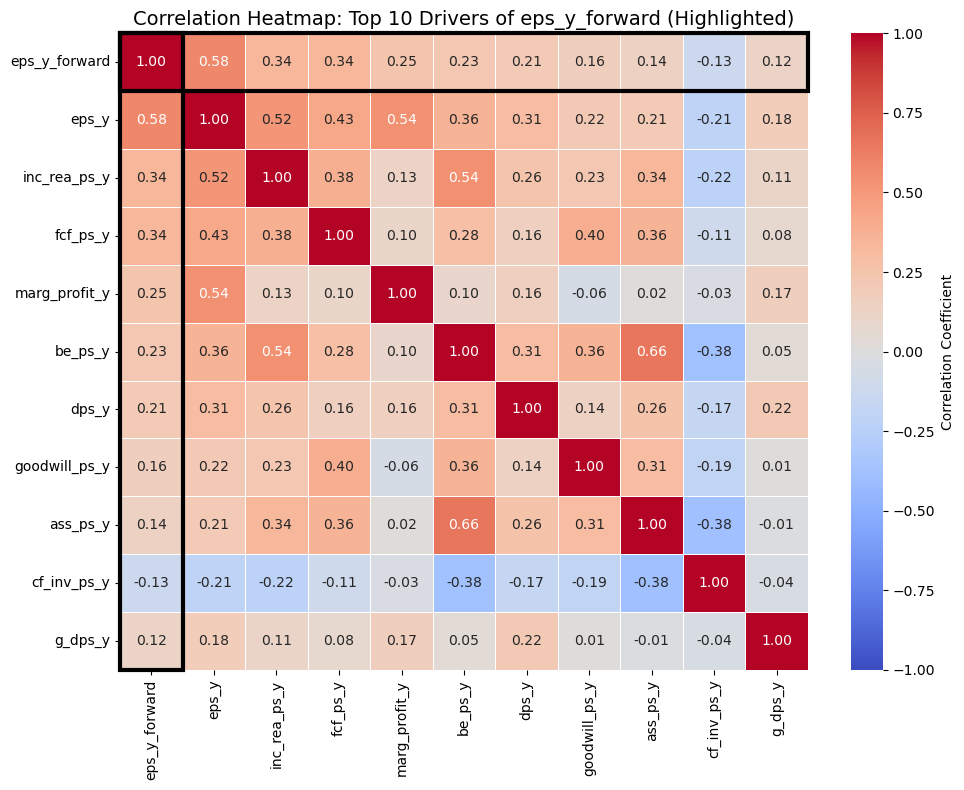

In [58]:
# 1. Select only numeric columns
numeric_df = sp500_winsorized.select_dtypes(include=[np.number])
target = 'eps_y_forward'  # UPDATED TARGET

# Define columns to exclude from feature selection
EXCLUDE_FROM_FEATURES = ['neg_eps_forward', 'neg_eps', 'eps_y_forward']  # Exclude target and related variables

# 2. Select Top 10 Features + Target
if target in numeric_df.columns:
    # Filter out excluded columns before calculating correlations
    feature_candidates = numeric_df.drop(columns=EXCLUDE_FROM_FEATURES, errors='ignore')
    
    # Get correlations of remaining features against 'eps_y_forward'
    correlations = feature_candidates.corrwith(numeric_df[target]).abs()
    
    # Sort and take top 10 (best predictors only, excluding target)
    top_10_features = correlations.sort_values(ascending=False).head(10).index.tolist()
    
    # Add target back to create final feature list
    top_features = [target] + top_10_features
    
    print(f"Top 10 features correlated with {target}:")
    for i, feat in enumerate(top_10_features, 1):
        print(f"  {i}. {feat} (r = {correlations[feat]:.3f})")
    
    # 3. Create Heatmap
    plt.figure(figsize=(10, 8))
    corr_matrix = numeric_df[top_features].corr()
    
    # Plot heatmap
    ax = sns.heatmap(
        corr_matrix, 
        annot=True, 
        fmt=".2f", 
        cmap='coolwarm', 
        vmin=-1, vmax=1,
        linewidths=0.5,
        cbar_kws={'label': 'Correlation Coefficient'}
    )
    
    # 4. Highlight the Target Row and Column
    # Find where 'eps_y_forward' is in the list (should be index 0)
    target_idx = top_features.index(target)
    n_vars = len(top_features)
    
    # Draw Rectangle around the Target Column
    ax.add_patch(Rectangle((target_idx, 0), 1, n_vars, fill=False, edgecolor='black', lw=3, clip_on=False))
    
    # Draw Rectangle around the Target Row
    ax.add_patch(Rectangle((0, target_idx), n_vars, 1, fill=False, edgecolor='black', lw=3, clip_on=False))
    
    plt.title(f"Correlation Heatmap: Top 10 Drivers of {target} (Highlighted)", fontsize=14)
    plt.tight_layout()
    plt.show()

else:
    print(f"Target '{target}' not found in DataFrame. Did you run the shift code?")

From this visualization, we can see that profit margin, free cash flow per share, and book value per share are most highly correlated to the target variable (earning per share).

## 2. Modelling

### 2.1 Entire Time Span

As we move up in complexity and this is supposed to create a baseline, we use the simple approach of choosing the top 10 features with highest correlation to the target variable. Having in mind that this is likely to not yield the best results possible, it still gives us a first baseline to compare against, given the time constraints.
Also we will not scale the features, as it is not necessary for these simple models and helps interpretation.

In [43]:
features_trad = [
    'eps_y',
    'fcf_ps_y',        # Free Cash Flow per share
    'inc_rea_ps_y',    # Realized Income per share
    'be_ps_y',         # Book Equity per share
    'marg_profit_y',   # Profit Margin
    'dps_y',           # Dividends per share
    'goodwill_ps_y',   # Goodwill per share
    'ass_ps_y',        # Assets per share
    'cf_inv_ps_y',     # Cash Flow from Investing per share
    'g_eps_y',         # Growth in EPS
]

# Create the subset DataFrame
sp500_winsorized_X = sp500_winsorized[sp500_winsorized['year'] < 2016]




#### Regression

In [41]:
X_trad_all = sp500_winsorized_X[features_trad]
Y_reg_all = Y['eps_y_forward']

# 2. Fit the Linear Regression Model
lin_reg = LinearRegression()


lin_reg.fit(X_trad_all, Y_reg_all)

# 3. Create a Table of Factors (Coefficients)
factors_df = pd.DataFrame({
    'Feature': features_trad,
    'Factor (Coefficient)': lin_reg.coef_
})

# Add the Intercept as the first row (Optional, but good for completeness)
intercept_row = pd.DataFrame({'Feature': ['Intercept'], 'Factor (Coefficient)': [lin_reg.intercept_]})
factors_df = pd.concat([intercept_row, factors_df], ignore_index=True)

# 4. Print the Results
print("\n--- Regression Coefficients ---")
print(factors_df)


--- Regression Coefficients ---
          Feature  Factor (Coefficient)
0       Intercept              0.759976
1           eps_y              0.655343
2        fcf_ps_y              0.106421
3    inc_rea_ps_y              0.006037
4         be_ps_y             -0.004544
5   marg_profit_y             -1.544921
6           dps_y              0.109501
7   goodwill_ps_y             -0.001170
8        ass_ps_y             -0.001291
9     cf_inv_ps_y             -0.001490
10        g_eps_y             -0.179744


#### Interpretation of results
- Most of the coefficients are small - indicating either the scaling paradox or being a rather weak predictor
- Baseline Expectation: The Intercept (0.76) sets a positive baseline for future earnings, reflecting the inherent long-term upward trend in earnings of S&P 500 companies
- Primary Driver (Persistence): Current earnings per share (eps_y) is the strongest predictor (+0.66), implying that $0.66 of every dollar earned today persists into next year regardless of other factors
- The Scaling Paradox: Features with large numerical values (e.g., ass_ps_y) naturally display tiny coefficients (-0.001) to offset their magnitude. This is a mathematical adjustment, not necessarily a sign of insignificance
- Quality Signals: Both Free Cash Flow (fcf_ps_y, +0.11) and Dividends (dps_y, +0.11) are positive predictors, confirming that cash generation and management confidence (payouts) signal stability
- Growth Reversion: The negative coefficient for EPS Growth (g_eps_y, -0.18) might indicate that high-growth companies are statistically likely to slow down in following years
- Margin: Profit Margin (marg_profit_y) has a large negative coefficient (-1.54) - this could be due to collinearity with e.g. eps_y weakening the strong effect on the dependent variable
- Other potential margin interpretation (Competition): Extremely high profit margins attract competition, leading to price erosion and margin contraction in subsequent years.


#### Classification

In [42]:
Y_class_all = Y['neg_eps_forward']


# 3. Fit Logistic Regression
# max_iter=1000 ensures it converges even with unscaled data
log_reg = LogisticRegression(fit_intercept=True, max_iter=1000) 
log_reg.fit(X_trad_all, Y_class_all)

# 4. Create Table of Factors (Coefficients)
log_factors_df = pd.DataFrame({
    'Feature': features_trad,
    'Factor (Coefficient)': log_reg.coef_[0] # Note the [0] index for binary classification
})

# Add Intercept
intercept_row = pd.DataFrame({'Feature': ['Intercept'], 'Factor (Coefficient)': [log_reg.intercept_[0]]})
log_factors_df = pd.concat([intercept_row, log_factors_df], ignore_index=True)

# 5. Print Results
print("\n--- Logistic Regression Coefficients (Log-Odds) ---")
print(log_factors_df)


--- Logistic Regression Coefficients (Log-Odds) ---
          Feature  Factor (Coefficient)
0       Intercept             -1.769123
1           eps_y             -0.289012
2        fcf_ps_y             -0.048876
3    inc_rea_ps_y             -0.010969
4         be_ps_y              0.019254
5   marg_profit_y             -3.056704
6           dps_y             -0.137119
7   goodwill_ps_y             -0.000106
8        ass_ps_y              0.004497
9     cf_inv_ps_y             -0.002197
10        g_eps_y              0.036708


#### Interpretation of results
- Baseline Probability (Safety): The Intercept is strongly negative (-1.77) confirming that the "default state" of an S&P 500 company is profitable - the probability of a company posting a loss (without knowing any other data) is statistically low
- The "Buffer" Effect (Profit Margin): Unlike the linear regression where margins were penalized, marg_profit_y has a massive negative coefficient (-3.06)
- Interpretation: High margins provide a massive safety buffer. Even if a company with 40% margins suffers a setback, they might drop to 20% profitability, but they are unlikely to drop below zero into a loss
- Primary Defense (Persistence): Current EPS (eps_y) is negative (-0.29) but significantly lower than other coefficients, confirming, however, that current profitability is a good insurance against future loss
- Quality Signaling: Dividends (dps_y, -0.14) and Free Cash Flow (fcf_ps_y, -0.05) significantly reduce risk - companies that pay dividends signal they have excess cash liquidity, making a sudden shift to negative earnings unlikely.
- The Volatility Penalty: EPS Growth (g_eps_y) is positive (+0.04), meaning high growth increases the risk of a loss. Hyper-growth companies are volatile; if they miss their targets, they crash harder than stable, low-growth firms.
- The Scaling Paradox: ass_ps_y (Assets) and inc_rea_ps_y show very small coefficients due to their large numerical values. While ass_ps_y is positive (indicating larger, bloated balance sheets might carry slightly more inertia risk), the magnitude is mathematically compressed.

- Model Contrast (Key Insight): The most important finding is the behavior of Profit Margin.
    - In Linear Model: It was negative (Margins revert to mean, dragging down growth).
    - In Logistic Model: It is negative (Margins prevent losses).
    - Conclusion could be: High margins limit your upside growth (due to competition) but protect your downside survival.

### 2.2 Model Evaluation on 2016 data

#### Regression

In [60]:
X_train = sp500_winsorized_X[sp500_winsorized_X['year'] < 2015]
X_train = X_train[features_trad]

X_test = sp500_winsorized_X[sp500_winsorized_X['year'] == 2015]
X_test = X_test_reg[features_trad]

Y_train_reg = Y[Y['year'] < 2015]
Y_train_reg = Y_train_reg['eps_y_forward']

Y_test_reg = Y[Y['year'] == 2015]
Y_test_reg = Y_test_reg['eps_y_forward']

Y_test_reg

print(f"Training Samples (2007-2014): {len(X_train)}")
print(f"Testing Samples (2015 predicting 2016): {len(X_test_reg)}")

# 3. Fit the Model
lin_reg_triv = LinearRegression()
lin_reg_triv.fit(X_train, Y_train_reg)

# 4. Predict
Y_pred_reg = lin_reg_triv.predict(X_test_reg)

# 5. Evaluate

mse_test = mean_squared_error(Y_test_reg, Y_pred_reg)
r2_test = r2_score(Y_test_reg, Y_pred_reg)
rmse_test = np.sqrt(mse_test) # Root MSE is easier to interpret ($)

# 6. Print Results
print("\n--- Model Evaluation (Out-of-Sample) ---")
print(f"Test R²:  {r2_test:.4f}")
print("-" * 30)
print(f"Test MSE: {mse_test:.4f}")
print(f"Test RMSE: ${rmse_test:.2f} per share")

Training Samples (2007-2014): 4203
Testing Samples (2015 predicting 2016): 553

--- Model Evaluation (Out-of-Sample) ---
Test R²:  0.5867
------------------------------
Test MSE: 5.2021
Test RMSE: $2.28 per share


#### Interpretation

- R^2: The model captures nearly 60% of the variance in next year’s earnings is a reasonable fit - however, R^2 also increases with the number of features included in the model (that do not necessarily add value), so this is to be seen with a grain of salt
- Poor Performance: The Root Mean Squared Error ($2.28) is nearly identical to the average EPS ($2.33) - indicating high relative error 
- Baseline Performance: Relatively poor performance - to be compared to more sophisticated models


#### Classification

In [84]:
Y_train_class = Y[Y['year'] < 2015]
Y_train_class = Y_train_class['neg_eps_forward']

Y_test_class = Y[Y['year'] == 2015]
Y_test_class = Y_test_class['neg_eps_forward']

# 1. Fit the Logistic Regression Model
# We use the new Class targets (Y_train_class, Y_test_class)
log_reg_split = LogisticRegression(fit_intercept=True, max_iter=1000) 
log_reg_split.fit(X_train, Y_train_class)

# 2. Predict
y_pred_train_class = log_reg_split.predict(X_train)
y_pred_test_class = log_reg_split.predict(X_test)

# 3. Evaluate (Accuracy)
acc_train = accuracy_score(Y_train_class, y_pred_train_class)
acc_test = accuracy_score(Y_test_class, y_pred_test_class)

# 4. Create Table of Factors (Coefficients)
log_factors_split_df = pd.DataFrame({
    'Feature': features_trad,
    'Factor (Coefficient)': log_reg_split.coef_[0]
})

# Add Intercept
intercept_row = pd.DataFrame({'Feature': ['Intercept'], 'Factor (Coefficient)': [log_reg_split.intercept_[0]]})
log_factors_split_df = pd.concat([intercept_row, log_factors_split_df], ignore_index=True)

# 5. Print Results
print("\n--- Classification Model Evaluation (Out-of-Sample) ---")

print(f"Train Accuracy: {acc_train:.4f} ({(acc_train*100):.2f}%)")
print(f"Test Accuracy:  {acc_test:.4f}  ({(acc_test*100):.2f}%)")

print("\n--- Logistic Regression Coefficients (Log-Odds) ---")
print(log_factors_split_df)



--- Classification Model Evaluation (Out-of-Sample) ---
Train Accuracy: 0.8896 (88.96%)
Test Accuracy:  0.8861  (88.61%)

--- Logistic Regression Coefficients (Log-Odds) ---
          Feature  Factor (Coefficient)
0       Intercept             -1.836016
1           eps_y             -0.267652
2        fcf_ps_y             -0.040020
3    inc_rea_ps_y             -0.012729
4         be_ps_y              0.015939
5   marg_profit_y             -2.857976
6           dps_y             -0.136042
7   goodwill_ps_y              0.000734
8        ass_ps_y              0.005235
9     cf_inv_ps_y             -0.002166
10        g_eps_y              0.074214


At first sight, 88.61% accuracy seems to be a good result. However, when comparing the data to the distribution in the dataset, we can see that the majority of the data is 0 (no negative earnings).

In [76]:
neg_ratio = Y['neg_eps_forward'].mean()
neg_ratio

0.1276282590412111

The model performs as well as a random guess. This could show that the model just predicts the majority class (0) all the time - lets assess this.

In [ ]:
print(pd.Series(y_pred_test_class).value_counts(normalize=True))

0.0    0.938517
1.0    0.061483
Name: proportion, dtype: float64


- Even though the model predicts non-negative earnings more often, it does not 'just' always predict 0, which is a good indicator
- As train & test accuracy are similar, there is no indication of extreme overfitting
- Overall the model works as a solid baseline - we could show that there are no major issues that would make the model questionable
- Again the profit margin is the largest indicator for a positive earnings in the future
- The intercept is very large again, indicating a general tendency for positive earnings

In [22]:
Y.tail()

,ticker,date,year,month,day,fyear,fmonth,shr_y,ass_ps_y,goodwill_ps_y,...,g_inv_y,be_ps_y,fcf_ps_y,inc_qua_y,payout_y,turn_inv_y,eps_y,neg_eps,eps_y_forward,neg_eps_forward
v1,,,,,,,,,,,,,,,,,,,,,
5472,zts,2011-12-31,2011,12,31,2011,12,500000000.0,11.422000,3.834000,...,0.0683,7.440,0.724,2.0286,0.000,4.1137,0.49,0,0.87,0.0
5473,zts,2012-12-31,2012,12,31,2012,12,500000000.0,12.524000,3.706000,...,0.2653,8.052,0.656,1.0413,0.000,3.6013,0.87,0,1.01,0.0
5474,zts,2013-12-31,2013,12,31,2013,12,500002000.0,13.115948,3.569986,...,-0.0387,1.880,0.994,1.3512,0.198,3.4579,1.01,0,1.16,0.0
5475,zts,2014-12-31,2014,12,31,2014,12,501055000.0,13.148257,3.398828,...,-0.0031,2.614,0.890,1.0738,0.250,3.7064,1.16,0,0.68,0.0
5476,zts,2015-12-31,2015,12,31,2015,12,499707000.0,15.835279,5.293102,...,0.1381,2.144,0.881,1.9587,0.485,3.4579,0.68,0,1.66,0.0


### 2.2 - Additional Model Elastic Net